In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import time
import datetime as dt
import random
import psutil
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle
import glob
import pickle
import torchvision
from torch.optim import lr_scheduler
import torch.nn.functional as F
import math
import time

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def no_of_params(model):
    sum_ = 0.
    for key, value in model.state_dict().items():
        sum_ += torch.prod(torch.tensor(value.shape))
        #print(value, "----------", torch.prod(torch.tensor(value.shape)))
    return int(sum_)

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        list_IDs,
    ):
        self.list_IDs  = list_IDs
        self.cache     = {}
        self.input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/images/"
        self.label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/labels/"
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        if ID in self.cache:
            X = self.cache[ID]['X']
            Y = self.cache[ID]['Y']
        else:
            X = torchvision.io.read_image(
                self.input_dir + str(ID) + ".png "
            ).to(torch.float64)
            X = X[1].unsqueeze(0)/256.
            
            with open(self.label_dir + str(ID), 'rb') as fb:
                Y  = pickle.load(fb)
                
            #Y = [ (i + 3.)/6. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            #Y = [ i/3. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            
            Y = Y[1][0]/3.1415926
            Y = Y - 0.5
            
            Y = torch.tensor( Y, dtype=torch.float64 ).unsqueeze(0)
            
            if psutil.virtual_memory().percent < 50:
                data = {
                    'X' : X,
                    'Y' : Y
                }
                self.cache[ID] = data
        return X,Y
    
all_ids = [str(i) for i in  list(np.arange(0,10000,1))]
#train_ids = all_ids[:8000]
#val_ids   = all_ids[8000:]#1000]

train_ids = all_ids[:800]
val_ids   = all_ids[800:1000]#1000]

params = {
    'batch_size'  : 8,
    'shuffle'     : True,
    #'num_workers' : 2
}
training_set         = Dataset(train_ids)
training_generator   = torch.utils.data.DataLoader(
                            training_set,
                            **params,
                            pin_memory=True
                        )
validation_set       = Dataset(val_ids)
validation_generator = torch.utils.data.DataLoader(
                            validation_set,
                            **params,
                            pin_memory=True
                        )

In [10]:
def train_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    #loss_fn = nn.L1Loss()
    
    model.train(True)
    
    for i,batch in enumerate(training_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

def validate_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    #loss_fn = nn.L1Loss()
    model.train(False)
    model.eval()
    
    for i,batch in enumerate(validation_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        #optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

In [26]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1  = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=1)
        self.bn1    = nn.BatchNorm2d(8)
        self.conv2  = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.bn2    = nn.BatchNorm2d(16)
        self.pool   = nn.MaxPool2d(2,2)
        self.conv4  = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=1)
        self.bn4    = nn.BatchNorm2d(32)
        self.conv5  = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.bn5    = nn.BatchNorm2d(64)
        self.fc1    = nn.Linear(64*10*10, 1)

    def forward(self, input):
        output = torch.tanh(self.bn1(self.conv1(input)))      
        output = torch.tanh(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = torch.tanh(self.bn4(self.conv4(output)))     
        output = torch.tanh(self.bn5(self.conv5(output))) 
        #print(output.shape)
        output = output.view(-1, 64*10*10)
        output = self.fc1(output)
        output = torch.tanh(output)

        return output

torch.set_default_tensor_type(torch.DoubleTensor)
model = Network()
no_of_params(model)

74405

In [27]:
lr = 1e-7
wd = 1e-3
model = Network()

epochs = 5000
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd,
    )

gamma = 0.998
scheduler = lr_scheduler.ExponentialLR(
    optimizer, 
    gamma     = gamma)

train_losses = []
val_losses   = []
lrs          = []
for epoch in range(epochs):
    train_loss = train_one_epoch(model,optimizer)
    val_loss   = validate_one_epoch(model,optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    #optimizer.step()
    lrs.append(scheduler.optimizer.param_groups[0]['lr'])
    scheduler.step()
    print("EPOCH: ",epoch + 1, " Train loss: ", round(train_loss,6), " Val loss: ",round(val_loss,6), " LR: ",round(scheduler.optimizer.param_groups[0]['lr'],10))

EPOCH:  1  Train loss:  0.192099  Val loss:  0.163406  LR:  9.98e-08
EPOCH:  2  Train loss:  0.157466  Val loss:  0.133211  LR:  9.96e-08
EPOCH:  3  Train loss:  0.127565  Val loss:  0.105506  LR:  9.94e-08
EPOCH:  4  Train loss:  0.101  Val loss:  0.084009  LR:  9.92e-08
EPOCH:  5  Train loss:  0.078183  Val loss:  0.065285  LR:  9.9e-08
EPOCH:  6  Train loss:  0.060802  Val loss:  0.049846  LR:  9.88e-08
EPOCH:  7  Train loss:  0.046121  Val loss:  0.037611  LR:  9.86e-08
EPOCH:  8  Train loss:  0.03496  Val loss:  0.029392  LR:  9.84e-08
EPOCH:  9  Train loss:  0.027193  Val loss:  0.024009  LR:  9.82e-08
EPOCH:  10  Train loss:  0.022551  Val loss:  0.020903  LR:  9.8e-08
EPOCH:  11  Train loss:  0.01961  Val loss:  0.019914  LR:  9.78e-08
EPOCH:  12  Train loss:  0.018736  Val loss:  0.020283  LR:  9.76e-08
EPOCH:  13  Train loss:  0.01921  Val loss:  0.022121  LR:  9.74e-08
EPOCH:  14  Train loss:  0.021158  Val loss:  0.024708  LR:  9.72e-08
EPOCH:  15  Train loss:  0.023499  Va

EPOCH:  119  Train loss:  0.011327  Val loss:  0.012551  LR:  7.88e-08
EPOCH:  120  Train loss:  0.011189  Val loss:  0.01252  LR:  7.86e-08
EPOCH:  121  Train loss:  0.011017  Val loss:  0.012153  LR:  7.85e-08
EPOCH:  122  Train loss:  0.010978  Val loss:  0.012021  LR:  7.83e-08
EPOCH:  123  Train loss:  0.010882  Val loss:  0.01244  LR:  7.82e-08
EPOCH:  124  Train loss:  0.010716  Val loss:  0.011943  LR:  7.8e-08
EPOCH:  125  Train loss:  0.010663  Val loss:  0.012436  LR:  7.79e-08
EPOCH:  126  Train loss:  0.010859  Val loss:  0.012656  LR:  7.77e-08
EPOCH:  127  Train loss:  0.010949  Val loss:  0.01246  LR:  7.75e-08
EPOCH:  128  Train loss:  0.01095  Val loss:  0.013096  LR:  7.74e-08
EPOCH:  129  Train loss:  0.011188  Val loss:  0.01302  LR:  7.72e-08
EPOCH:  130  Train loss:  0.011695  Val loss:  0.013326  LR:  7.71e-08
EPOCH:  131  Train loss:  0.011794  Val loss:  0.013754  LR:  7.69e-08
EPOCH:  132  Train loss:  0.012131  Val loss:  0.014386  LR:  7.68e-08
EPOCH:  133 

EPOCH:  235  Train loss:  0.00229  Val loss:  0.002117  LR:  6.25e-08
EPOCH:  236  Train loss:  0.002175  Val loss:  0.002023  LR:  6.23e-08
EPOCH:  237  Train loss:  0.002147  Val loss:  0.00196  LR:  6.22e-08
EPOCH:  238  Train loss:  0.002119  Val loss:  0.001881  LR:  6.21e-08
EPOCH:  239  Train loss:  0.001977  Val loss:  0.001808  LR:  6.2e-08
EPOCH:  240  Train loss:  0.00197  Val loss:  0.001779  LR:  6.18e-08
EPOCH:  241  Train loss:  0.001912  Val loss:  0.001782  LR:  6.17e-08
EPOCH:  242  Train loss:  0.001863  Val loss:  0.001753  LR:  6.16e-08
EPOCH:  243  Train loss:  0.00182  Val loss:  0.001669  LR:  6.15e-08
EPOCH:  244  Train loss:  0.00179  Val loss:  0.001673  LR:  6.14e-08
EPOCH:  245  Train loss:  0.001756  Val loss:  0.001696  LR:  6.12e-08
EPOCH:  246  Train loss:  0.001758  Val loss:  0.001627  LR:  6.11e-08
EPOCH:  247  Train loss:  0.001696  Val loss:  0.0016  LR:  6.1e-08
EPOCH:  248  Train loss:  0.001703  Val loss:  0.001632  LR:  6.09e-08
EPOCH:  249  Tr

EPOCH:  352  Train loss:  0.00051  Val loss:  0.000533  LR:  4.94e-08
EPOCH:  353  Train loss:  0.000498  Val loss:  0.000516  LR:  4.93e-08
EPOCH:  354  Train loss:  0.000495  Val loss:  0.000519  LR:  4.92e-08
EPOCH:  355  Train loss:  0.000499  Val loss:  0.000516  LR:  4.91e-08
EPOCH:  356  Train loss:  0.000471  Val loss:  0.000499  LR:  4.9e-08
EPOCH:  357  Train loss:  0.000466  Val loss:  0.000507  LR:  4.89e-08
EPOCH:  358  Train loss:  0.000501  Val loss:  0.000496  LR:  4.88e-08
EPOCH:  359  Train loss:  0.000474  Val loss:  0.000485  LR:  4.87e-08
EPOCH:  360  Train loss:  0.000465  Val loss:  0.000484  LR:  4.86e-08
EPOCH:  361  Train loss:  0.000456  Val loss:  0.000475  LR:  4.85e-08
EPOCH:  362  Train loss:  0.000483  Val loss:  0.000464  LR:  4.84e-08
EPOCH:  363  Train loss:  0.000464  Val loss:  0.000474  LR:  4.83e-08
EPOCH:  364  Train loss:  0.000458  Val loss:  0.000473  LR:  4.83e-08
EPOCH:  365  Train loss:  0.000466  Val loss:  0.00045  LR:  4.82e-08
EPOCH:  3

EPOCH:  468  Train loss:  0.000389  Val loss:  0.00042  LR:  3.92e-08
EPOCH:  469  Train loss:  0.000402  Val loss:  0.000403  LR:  3.91e-08
EPOCH:  470  Train loss:  0.000387  Val loss:  0.000407  LR:  3.9e-08
EPOCH:  471  Train loss:  0.000386  Val loss:  0.000405  LR:  3.89e-08
EPOCH:  472  Train loss:  0.00038  Val loss:  0.000397  LR:  3.89e-08
EPOCH:  473  Train loss:  0.000389  Val loss:  0.000407  LR:  3.88e-08
EPOCH:  474  Train loss:  0.000366  Val loss:  0.000398  LR:  3.87e-08
EPOCH:  475  Train loss:  0.000383  Val loss:  0.000405  LR:  3.86e-08
EPOCH:  476  Train loss:  0.000373  Val loss:  0.000389  LR:  3.86e-08
EPOCH:  477  Train loss:  0.000384  Val loss:  0.000421  LR:  3.85e-08
EPOCH:  478  Train loss:  0.000398  Val loss:  0.000399  LR:  3.84e-08
EPOCH:  479  Train loss:  0.000384  Val loss:  0.000406  LR:  3.83e-08
EPOCH:  480  Train loss:  0.000387  Val loss:  0.000392  LR:  3.83e-08
EPOCH:  481  Train loss:  0.000371  Val loss:  0.000385  LR:  3.82e-08
EPOCH:  4

EPOCH:  584  Train loss:  0.000243  Val loss:  0.00025  LR:  3.11e-08
EPOCH:  585  Train loss:  0.000236  Val loss:  0.000237  LR:  3.1e-08
EPOCH:  586  Train loss:  0.000234  Val loss:  0.000256  LR:  3.09e-08
EPOCH:  587  Train loss:  0.000247  Val loss:  0.000253  LR:  3.09e-08
EPOCH:  588  Train loss:  0.000237  Val loss:  0.000238  LR:  3.08e-08
EPOCH:  589  Train loss:  0.000239  Val loss:  0.000239  LR:  3.08e-08
EPOCH:  590  Train loss:  0.000234  Val loss:  0.00024  LR:  3.07e-08
EPOCH:  591  Train loss:  0.000238  Val loss:  0.000239  LR:  3.06e-08
EPOCH:  592  Train loss:  0.000234  Val loss:  0.000237  LR:  3.06e-08
EPOCH:  593  Train loss:  0.000244  Val loss:  0.000241  LR:  3.05e-08
EPOCH:  594  Train loss:  0.000234  Val loss:  0.000239  LR:  3.04e-08
EPOCH:  595  Train loss:  0.000239  Val loss:  0.000233  LR:  3.04e-08
EPOCH:  596  Train loss:  0.000241  Val loss:  0.000238  LR:  3.03e-08
EPOCH:  597  Train loss:  0.000226  Val loss:  0.000236  LR:  3.03e-08
EPOCH:  5

EPOCH:  700  Train loss:  0.000163  Val loss:  0.00017  LR:  2.46e-08
EPOCH:  701  Train loss:  0.000163  Val loss:  0.000168  LR:  2.46e-08
EPOCH:  702  Train loss:  0.000168  Val loss:  0.000171  LR:  2.45e-08
EPOCH:  703  Train loss:  0.00017  Val loss:  0.000169  LR:  2.45e-08
EPOCH:  704  Train loss:  0.000166  Val loss:  0.000168  LR:  2.44e-08
EPOCH:  705  Train loss:  0.000165  Val loss:  0.000174  LR:  2.44e-08
EPOCH:  706  Train loss:  0.000171  Val loss:  0.000176  LR:  2.43e-08
EPOCH:  707  Train loss:  0.000172  Val loss:  0.000178  LR:  2.43e-08
EPOCH:  708  Train loss:  0.000155  Val loss:  0.00017  LR:  2.42e-08
EPOCH:  709  Train loss:  0.000158  Val loss:  0.000166  LR:  2.42e-08
EPOCH:  710  Train loss:  0.000155  Val loss:  0.000162  LR:  2.41e-08
EPOCH:  711  Train loss:  0.000166  Val loss:  0.000167  LR:  2.41e-08
EPOCH:  712  Train loss:  0.000166  Val loss:  0.000159  LR:  2.4e-08
EPOCH:  713  Train loss:  0.000164  Val loss:  0.000164  LR:  2.4e-08
EPOCH:  714

EPOCH:  817  Train loss:  0.000131  Val loss:  0.000141  LR:  1.95e-08
EPOCH:  818  Train loss:  0.000138  Val loss:  0.00015  LR:  1.94e-08
EPOCH:  819  Train loss:  0.000143  Val loss:  0.000139  LR:  1.94e-08
EPOCH:  820  Train loss:  0.000135  Val loss:  0.000138  LR:  1.94e-08
EPOCH:  821  Train loss:  0.000126  Val loss:  0.000143  LR:  1.93e-08
EPOCH:  822  Train loss:  0.000147  Val loss:  0.000141  LR:  1.93e-08
EPOCH:  823  Train loss:  0.000142  Val loss:  0.00015  LR:  1.93e-08
EPOCH:  824  Train loss:  0.000137  Val loss:  0.000142  LR:  1.92e-08
EPOCH:  825  Train loss:  0.000142  Val loss:  0.00014  LR:  1.92e-08
EPOCH:  826  Train loss:  0.000128  Val loss:  0.000136  LR:  1.91e-08
EPOCH:  827  Train loss:  0.00013  Val loss:  0.000142  LR:  1.91e-08
EPOCH:  828  Train loss:  0.00013  Val loss:  0.000139  LR:  1.91e-08
EPOCH:  829  Train loss:  0.000139  Val loss:  0.000145  LR:  1.9e-08
EPOCH:  830  Train loss:  0.000127  Val loss:  0.000139  LR:  1.9e-08
EPOCH:  831  

EPOCH:  933  Train loss:  0.000117  Val loss:  0.000124  LR:  1.54e-08
EPOCH:  934  Train loss:  0.000117  Val loss:  0.00012  LR:  1.54e-08
EPOCH:  935  Train loss:  0.000116  Val loss:  0.00012  LR:  1.54e-08
EPOCH:  936  Train loss:  0.000118  Val loss:  0.000123  LR:  1.54e-08
EPOCH:  937  Train loss:  0.000109  Val loss:  0.000123  LR:  1.53e-08
EPOCH:  938  Train loss:  0.000105  Val loss:  0.000123  LR:  1.53e-08
EPOCH:  939  Train loss:  0.000116  Val loss:  0.00012  LR:  1.53e-08
EPOCH:  940  Train loss:  0.000111  Val loss:  0.000122  LR:  1.52e-08
EPOCH:  941  Train loss:  0.00011  Val loss:  0.000119  LR:  1.52e-08
EPOCH:  942  Train loss:  0.000115  Val loss:  0.00012  LR:  1.52e-08
EPOCH:  943  Train loss:  0.000112  Val loss:  0.000118  LR:  1.51e-08
EPOCH:  944  Train loss:  0.00011  Val loss:  0.000118  LR:  1.51e-08
EPOCH:  945  Train loss:  0.000108  Val loss:  0.000128  LR:  1.51e-08
EPOCH:  946  Train loss:  0.000118  Val loss:  0.000117  LR:  1.5e-08
EPOCH:  947  

EPOCH:  1049  Train loss:  0.000101  Val loss:  0.000103  LR:  1.22e-08
EPOCH:  1050  Train loss:  0.0001  Val loss:  0.000102  LR:  1.22e-08
EPOCH:  1051  Train loss:  0.0001  Val loss:  0.000103  LR:  1.22e-08
EPOCH:  1052  Train loss:  0.000101  Val loss:  0.000107  LR:  1.22e-08
EPOCH:  1053  Train loss:  8.9e-05  Val loss:  0.000101  LR:  1.21e-08
EPOCH:  1054  Train loss:  9.6e-05  Val loss:  0.000101  LR:  1.21e-08
EPOCH:  1055  Train loss:  8.6e-05  Val loss:  0.000101  LR:  1.21e-08
EPOCH:  1056  Train loss:  8.8e-05  Val loss:  0.000103  LR:  1.21e-08
EPOCH:  1057  Train loss:  9e-05  Val loss:  0.000101  LR:  1.2e-08
EPOCH:  1058  Train loss:  9.7e-05  Val loss:  0.000102  LR:  1.2e-08
EPOCH:  1059  Train loss:  0.000101  Val loss:  0.000102  LR:  1.2e-08
EPOCH:  1060  Train loss:  9.1e-05  Val loss:  0.000102  LR:  1.2e-08
EPOCH:  1061  Train loss:  0.000103  Val loss:  0.000104  LR:  1.2e-08
EPOCH:  1062  Train loss:  8.6e-05  Val loss:  0.0001  LR:  1.19e-08
EPOCH:  1063 

EPOCH:  1167  Train loss:  8.1e-05  Val loss:  8.5e-05  LR:  9.7e-09
EPOCH:  1168  Train loss:  8.1e-05  Val loss:  8.5e-05  LR:  9.6e-09
EPOCH:  1169  Train loss:  8.6e-05  Val loss:  8.4e-05  LR:  9.6e-09
EPOCH:  1170  Train loss:  7.6e-05  Val loss:  8.8e-05  LR:  9.6e-09
EPOCH:  1171  Train loss:  8e-05  Val loss:  8.2e-05  LR:  9.6e-09
EPOCH:  1172  Train loss:  8.3e-05  Val loss:  8.7e-05  LR:  9.6e-09
EPOCH:  1173  Train loss:  8.1e-05  Val loss:  8.3e-05  LR:  9.6e-09
EPOCH:  1174  Train loss:  8.7e-05  Val loss:  8.6e-05  LR:  9.5e-09
EPOCH:  1175  Train loss:  7.7e-05  Val loss:  8.3e-05  LR:  9.5e-09
EPOCH:  1176  Train loss:  8.2e-05  Val loss:  8.3e-05  LR:  9.5e-09
EPOCH:  1177  Train loss:  7.9e-05  Val loss:  8.4e-05  LR:  9.5e-09
EPOCH:  1178  Train loss:  7.5e-05  Val loss:  8.1e-05  LR:  9.5e-09
EPOCH:  1179  Train loss:  7.7e-05  Val loss:  8.2e-05  LR:  9.4e-09
EPOCH:  1180  Train loss:  7.4e-05  Val loss:  8.3e-05  LR:  9.4e-09
EPOCH:  1181  Train loss:  7.9e-05  

EPOCH:  1287  Train loss:  7.1e-05  Val loss:  7e-05  LR:  7.6e-09
EPOCH:  1288  Train loss:  6.9e-05  Val loss:  7.3e-05  LR:  7.6e-09
EPOCH:  1289  Train loss:  6.8e-05  Val loss:  7.1e-05  LR:  7.6e-09
EPOCH:  1290  Train loss:  7.1e-05  Val loss:  7.1e-05  LR:  7.6e-09
EPOCH:  1291  Train loss:  6.3e-05  Val loss:  7.2e-05  LR:  7.5e-09
EPOCH:  1292  Train loss:  7.2e-05  Val loss:  7.1e-05  LR:  7.5e-09
EPOCH:  1293  Train loss:  7.4e-05  Val loss:  6.8e-05  LR:  7.5e-09
EPOCH:  1294  Train loss:  6.9e-05  Val loss:  7e-05  LR:  7.5e-09
EPOCH:  1295  Train loss:  6.5e-05  Val loss:  6.9e-05  LR:  7.5e-09
EPOCH:  1296  Train loss:  6.8e-05  Val loss:  6.8e-05  LR:  7.5e-09
EPOCH:  1297  Train loss:  6.3e-05  Val loss:  6.8e-05  LR:  7.5e-09
EPOCH:  1298  Train loss:  7e-05  Val loss:  7.4e-05  LR:  7.4e-09
EPOCH:  1299  Train loss:  6.7e-05  Val loss:  7e-05  LR:  7.4e-09
EPOCH:  1300  Train loss:  6.7e-05  Val loss:  7.1e-05  LR:  7.4e-09
EPOCH:  1301  Train loss:  6.9e-05  Val lo

EPOCH:  1407  Train loss:  6.7e-05  Val loss:  6.5e-05  LR:  6e-09
EPOCH:  1408  Train loss:  6e-05  Val loss:  6.1e-05  LR:  6e-09
EPOCH:  1409  Train loss:  6.3e-05  Val loss:  6.2e-05  LR:  6e-09
EPOCH:  1410  Train loss:  6.2e-05  Val loss:  6.1e-05  LR:  5.9e-09
EPOCH:  1411  Train loss:  5.9e-05  Val loss:  6e-05  LR:  5.9e-09
EPOCH:  1412  Train loss:  6.9e-05  Val loss:  6.2e-05  LR:  5.9e-09
EPOCH:  1413  Train loss:  6.2e-05  Val loss:  6.2e-05  LR:  5.9e-09
EPOCH:  1414  Train loss:  6.1e-05  Val loss:  6.2e-05  LR:  5.9e-09
EPOCH:  1415  Train loss:  6.5e-05  Val loss:  6.3e-05  LR:  5.9e-09
EPOCH:  1416  Train loss:  6.1e-05  Val loss:  6.4e-05  LR:  5.9e-09
EPOCH:  1417  Train loss:  6e-05  Val loss:  6e-05  LR:  5.9e-09
EPOCH:  1418  Train loss:  7e-05  Val loss:  6.1e-05  LR:  5.8e-09
EPOCH:  1419  Train loss:  6.5e-05  Val loss:  6e-05  LR:  5.8e-09
EPOCH:  1420  Train loss:  6.1e-05  Val loss:  6.2e-05  LR:  5.8e-09
EPOCH:  1421  Train loss:  6e-05  Val loss:  6.1e-05

EPOCH:  1528  Train loss:  6.3e-05  Val loss:  5.4e-05  LR:  4.7e-09
EPOCH:  1529  Train loss:  6.1e-05  Val loss:  5.7e-05  LR:  4.7e-09
EPOCH:  1530  Train loss:  5.6e-05  Val loss:  5.6e-05  LR:  4.7e-09
EPOCH:  1531  Train loss:  6.1e-05  Val loss:  5.7e-05  LR:  4.7e-09
EPOCH:  1532  Train loss:  5.9e-05  Val loss:  5.5e-05  LR:  4.7e-09
EPOCH:  1533  Train loss:  6.1e-05  Val loss:  5.9e-05  LR:  4.6e-09
EPOCH:  1534  Train loss:  6.7e-05  Val loss:  5.4e-05  LR:  4.6e-09
EPOCH:  1535  Train loss:  6.5e-05  Val loss:  5.8e-05  LR:  4.6e-09
EPOCH:  1536  Train loss:  5.6e-05  Val loss:  5.6e-05  LR:  4.6e-09
EPOCH:  1537  Train loss:  6e-05  Val loss:  5.8e-05  LR:  4.6e-09
EPOCH:  1538  Train loss:  6e-05  Val loss:  5.6e-05  LR:  4.6e-09
EPOCH:  1539  Train loss:  6.1e-05  Val loss:  5.9e-05  LR:  4.6e-09
EPOCH:  1540  Train loss:  5.7e-05  Val loss:  6.2e-05  LR:  4.6e-09
EPOCH:  1541  Train loss:  5.8e-05  Val loss:  5.6e-05  LR:  4.6e-09
EPOCH:  1542  Train loss:  6.1e-05  Va

EPOCH:  1648  Train loss:  6e-05  Val loss:  5.4e-05  LR:  3.7e-09
EPOCH:  1649  Train loss:  6e-05  Val loss:  5.2e-05  LR:  3.7e-09
EPOCH:  1650  Train loss:  5.8e-05  Val loss:  5.4e-05  LR:  3.7e-09
EPOCH:  1651  Train loss:  5.9e-05  Val loss:  5.4e-05  LR:  3.7e-09
EPOCH:  1652  Train loss:  5.3e-05  Val loss:  5.7e-05  LR:  3.7e-09
EPOCH:  1653  Train loss:  5.7e-05  Val loss:  5.4e-05  LR:  3.7e-09
EPOCH:  1654  Train loss:  6.1e-05  Val loss:  5.3e-05  LR:  3.6e-09
EPOCH:  1655  Train loss:  5.6e-05  Val loss:  5.3e-05  LR:  3.6e-09
EPOCH:  1656  Train loss:  5.6e-05  Val loss:  5.4e-05  LR:  3.6e-09
EPOCH:  1657  Train loss:  5.5e-05  Val loss:  5.3e-05  LR:  3.6e-09
EPOCH:  1658  Train loss:  5.4e-05  Val loss:  5.4e-05  LR:  3.6e-09
EPOCH:  1659  Train loss:  6.2e-05  Val loss:  5.5e-05  LR:  3.6e-09
EPOCH:  1660  Train loss:  6e-05  Val loss:  5.4e-05  LR:  3.6e-09
EPOCH:  1661  Train loss:  6.2e-05  Val loss:  5.4e-05  LR:  3.6e-09
EPOCH:  1662  Train loss:  5.7e-05  Val 

EPOCH:  1768  Train loss:  5.7e-05  Val loss:  5.5e-05  LR:  2.9e-09
EPOCH:  1769  Train loss:  5.3e-05  Val loss:  5.3e-05  LR:  2.9e-09
EPOCH:  1770  Train loss:  5.7e-05  Val loss:  5.4e-05  LR:  2.9e-09
EPOCH:  1771  Train loss:  5.8e-05  Val loss:  5.3e-05  LR:  2.9e-09
EPOCH:  1772  Train loss:  5.6e-05  Val loss:  5.1e-05  LR:  2.9e-09
EPOCH:  1773  Train loss:  5.8e-05  Val loss:  5.1e-05  LR:  2.9e-09
EPOCH:  1774  Train loss:  6.1e-05  Val loss:  5.3e-05  LR:  2.9e-09
EPOCH:  1775  Train loss:  5.7e-05  Val loss:  5.2e-05  LR:  2.9e-09
EPOCH:  1776  Train loss:  5.7e-05  Val loss:  5.2e-05  LR:  2.9e-09
EPOCH:  1777  Train loss:  5.7e-05  Val loss:  5.2e-05  LR:  2.9e-09
EPOCH:  1778  Train loss:  5.6e-05  Val loss:  5.2e-05  LR:  2.8e-09
EPOCH:  1779  Train loss:  5.6e-05  Val loss:  5.4e-05  LR:  2.8e-09
EPOCH:  1780  Train loss:  5.8e-05  Val loss:  5.2e-05  LR:  2.8e-09
EPOCH:  1781  Train loss:  5.6e-05  Val loss:  5.2e-05  LR:  2.8e-09
EPOCH:  1782  Train loss:  5.5e-05

EPOCH:  1888  Train loss:  5.9e-05  Val loss:  5e-05  LR:  2.3e-09
EPOCH:  1889  Train loss:  5.2e-05  Val loss:  5.1e-05  LR:  2.3e-09
EPOCH:  1890  Train loss:  5.2e-05  Val loss:  5.1e-05  LR:  2.3e-09
EPOCH:  1891  Train loss:  5.6e-05  Val loss:  5e-05  LR:  2.3e-09
EPOCH:  1892  Train loss:  5.7e-05  Val loss:  5.3e-05  LR:  2.3e-09
EPOCH:  1893  Train loss:  5.6e-05  Val loss:  5e-05  LR:  2.3e-09
EPOCH:  1894  Train loss:  5.9e-05  Val loss:  5.1e-05  LR:  2.3e-09
EPOCH:  1895  Train loss:  5.4e-05  Val loss:  5.3e-05  LR:  2.3e-09
EPOCH:  1896  Train loss:  5.3e-05  Val loss:  5.3e-05  LR:  2.2e-09
EPOCH:  1897  Train loss:  5.7e-05  Val loss:  5.1e-05  LR:  2.2e-09
EPOCH:  1898  Train loss:  6e-05  Val loss:  5.2e-05  LR:  2.2e-09
EPOCH:  1899  Train loss:  5.1e-05  Val loss:  5.2e-05  LR:  2.2e-09
EPOCH:  1900  Train loss:  6.3e-05  Val loss:  5.2e-05  LR:  2.2e-09
EPOCH:  1901  Train loss:  5.9e-05  Val loss:  5.1e-05  LR:  2.2e-09
EPOCH:  1902  Train loss:  5.6e-05  Val lo

EPOCH:  2009  Train loss:  5.4e-05  Val loss:  5e-05  LR:  1.8e-09
EPOCH:  2010  Train loss:  5.6e-05  Val loss:  4.8e-05  LR:  1.8e-09
EPOCH:  2011  Train loss:  5.9e-05  Val loss:  5e-05  LR:  1.8e-09
EPOCH:  2012  Train loss:  5.3e-05  Val loss:  4.9e-05  LR:  1.8e-09
EPOCH:  2013  Train loss:  5.4e-05  Val loss:  5.1e-05  LR:  1.8e-09
EPOCH:  2014  Train loss:  5.8e-05  Val loss:  5.3e-05  LR:  1.8e-09
EPOCH:  2015  Train loss:  5.2e-05  Val loss:  5.1e-05  LR:  1.8e-09
EPOCH:  2016  Train loss:  5e-05  Val loss:  4.9e-05  LR:  1.8e-09
EPOCH:  2017  Train loss:  5.5e-05  Val loss:  5e-05  LR:  1.8e-09
EPOCH:  2018  Train loss:  5.5e-05  Val loss:  4.9e-05  LR:  1.8e-09
EPOCH:  2019  Train loss:  5.6e-05  Val loss:  5.2e-05  LR:  1.8e-09
EPOCH:  2020  Train loss:  5.7e-05  Val loss:  4.9e-05  LR:  1.8e-09
EPOCH:  2021  Train loss:  5.7e-05  Val loss:  5.2e-05  LR:  1.7e-09
EPOCH:  2022  Train loss:  5e-05  Val loss:  5e-05  LR:  1.7e-09
EPOCH:  2023  Train loss:  5.4e-05  Val loss: 

EPOCH:  2129  Train loss:  5.6e-05  Val loss:  5.2e-05  LR:  1.4e-09
EPOCH:  2130  Train loss:  5.5e-05  Val loss:  4.7e-05  LR:  1.4e-09
EPOCH:  2131  Train loss:  5.6e-05  Val loss:  5.1e-05  LR:  1.4e-09
EPOCH:  2132  Train loss:  5.2e-05  Val loss:  5e-05  LR:  1.4e-09
EPOCH:  2133  Train loss:  5.6e-05  Val loss:  5e-05  LR:  1.4e-09
EPOCH:  2134  Train loss:  5.8e-05  Val loss:  4.9e-05  LR:  1.4e-09
EPOCH:  2135  Train loss:  5.6e-05  Val loss:  4.7e-05  LR:  1.4e-09
EPOCH:  2136  Train loss:  5e-05  Val loss:  4.7e-05  LR:  1.4e-09
EPOCH:  2137  Train loss:  5.3e-05  Val loss:  4.9e-05  LR:  1.4e-09
EPOCH:  2138  Train loss:  5.1e-05  Val loss:  4.8e-05  LR:  1.4e-09
EPOCH:  2139  Train loss:  5.5e-05  Val loss:  5.1e-05  LR:  1.4e-09
EPOCH:  2140  Train loss:  5.4e-05  Val loss:  4.8e-05  LR:  1.4e-09
EPOCH:  2141  Train loss:  5.8e-05  Val loss:  4.9e-05  LR:  1.4e-09
EPOCH:  2142  Train loss:  5.5e-05  Val loss:  4.9e-05  LR:  1.4e-09
EPOCH:  2143  Train loss:  5.1e-05  Val 

EPOCH:  2249  Train loss:  5.5e-05  Val loss:  4.6e-05  LR:  1.1e-09
EPOCH:  2250  Train loss:  5.6e-05  Val loss:  4.9e-05  LR:  1.1e-09
EPOCH:  2251  Train loss:  5.1e-05  Val loss:  4.8e-05  LR:  1.1e-09
EPOCH:  2252  Train loss:  5.3e-05  Val loss:  4.7e-05  LR:  1.1e-09
EPOCH:  2253  Train loss:  5.1e-05  Val loss:  4.7e-05  LR:  1.1e-09
EPOCH:  2254  Train loss:  5e-05  Val loss:  4.9e-05  LR:  1.1e-09
EPOCH:  2255  Train loss:  5.5e-05  Val loss:  4.8e-05  LR:  1.1e-09
EPOCH:  2256  Train loss:  5.1e-05  Val loss:  4.8e-05  LR:  1.1e-09
EPOCH:  2257  Train loss:  5.3e-05  Val loss:  4.8e-05  LR:  1.1e-09
EPOCH:  2258  Train loss:  5.4e-05  Val loss:  4.9e-05  LR:  1.1e-09
EPOCH:  2259  Train loss:  5.3e-05  Val loss:  4.8e-05  LR:  1.1e-09
EPOCH:  2260  Train loss:  5.4e-05  Val loss:  4.9e-05  LR:  1.1e-09
EPOCH:  2261  Train loss:  5.3e-05  Val loss:  4.9e-05  LR:  1.1e-09
EPOCH:  2262  Train loss:  5e-05  Val loss:  4.7e-05  LR:  1.1e-09
EPOCH:  2263  Train loss:  5.5e-05  Va

EPOCH:  2371  Train loss:  5.4e-05  Val loss:  4.8e-05  LR:  9e-10
EPOCH:  2372  Train loss:  5.1e-05  Val loss:  4.9e-05  LR:  9e-10
EPOCH:  2373  Train loss:  5.3e-05  Val loss:  4.7e-05  LR:  9e-10
EPOCH:  2374  Train loss:  5.1e-05  Val loss:  5.1e-05  LR:  9e-10
EPOCH:  2375  Train loss:  5.6e-05  Val loss:  5.1e-05  LR:  9e-10
EPOCH:  2376  Train loss:  5.5e-05  Val loss:  4.7e-05  LR:  9e-10
EPOCH:  2377  Train loss:  5e-05  Val loss:  4.7e-05  LR:  9e-10
EPOCH:  2378  Train loss:  4.9e-05  Val loss:  4.7e-05  LR:  9e-10
EPOCH:  2379  Train loss:  5.1e-05  Val loss:  4.6e-05  LR:  9e-10
EPOCH:  2380  Train loss:  4.8e-05  Val loss:  4.6e-05  LR:  9e-10
EPOCH:  2381  Train loss:  5.3e-05  Val loss:  4.5e-05  LR:  9e-10
EPOCH:  2382  Train loss:  4.7e-05  Val loss:  4.7e-05  LR:  8e-10
EPOCH:  2383  Train loss:  5.1e-05  Val loss:  4.6e-05  LR:  8e-10
EPOCH:  2384  Train loss:  5e-05  Val loss:  4.6e-05  LR:  8e-10
EPOCH:  2385  Train loss:  5.2e-05  Val loss:  4.8e-05  LR:  8e-10

EPOCH:  2494  Train loss:  4.8e-05  Val loss:  4.9e-05  LR:  7e-10
EPOCH:  2495  Train loss:  5.2e-05  Val loss:  4.6e-05  LR:  7e-10
EPOCH:  2496  Train loss:  4.6e-05  Val loss:  4.4e-05  LR:  7e-10
EPOCH:  2497  Train loss:  5.3e-05  Val loss:  4.7e-05  LR:  7e-10
EPOCH:  2498  Train loss:  5e-05  Val loss:  4.9e-05  LR:  7e-10
EPOCH:  2499  Train loss:  4.8e-05  Val loss:  4.6e-05  LR:  7e-10
EPOCH:  2500  Train loss:  5.1e-05  Val loss:  4.5e-05  LR:  7e-10
EPOCH:  2501  Train loss:  4.8e-05  Val loss:  4.9e-05  LR:  7e-10
EPOCH:  2502  Train loss:  4.7e-05  Val loss:  4.9e-05  LR:  7e-10
EPOCH:  2503  Train loss:  4.8e-05  Val loss:  4.7e-05  LR:  7e-10
EPOCH:  2504  Train loss:  5e-05  Val loss:  4.6e-05  LR:  7e-10
EPOCH:  2505  Train loss:  4.6e-05  Val loss:  4.7e-05  LR:  7e-10
EPOCH:  2506  Train loss:  5.1e-05  Val loss:  4.6e-05  LR:  7e-10
EPOCH:  2507  Train loss:  4.9e-05  Val loss:  4.7e-05  LR:  7e-10
EPOCH:  2508  Train loss:  4.8e-05  Val loss:  4.8e-05  LR:  7e-10

EPOCH:  2618  Train loss:  4.9e-05  Val loss:  4.4e-05  LR:  5e-10
EPOCH:  2619  Train loss:  5.2e-05  Val loss:  4.7e-05  LR:  5e-10
EPOCH:  2620  Train loss:  4.9e-05  Val loss:  4.6e-05  LR:  5e-10
EPOCH:  2621  Train loss:  5.1e-05  Val loss:  5e-05  LR:  5e-10
EPOCH:  2622  Train loss:  5.4e-05  Val loss:  4.7e-05  LR:  5e-10
EPOCH:  2623  Train loss:  5.1e-05  Val loss:  4.9e-05  LR:  5e-10
EPOCH:  2624  Train loss:  5.6e-05  Val loss:  4.7e-05  LR:  5e-10
EPOCH:  2625  Train loss:  5.4e-05  Val loss:  4.4e-05  LR:  5e-10
EPOCH:  2626  Train loss:  5e-05  Val loss:  4.4e-05  LR:  5e-10
EPOCH:  2627  Train loss:  5.6e-05  Val loss:  4.6e-05  LR:  5e-10
EPOCH:  2628  Train loss:  5.1e-05  Val loss:  4.6e-05  LR:  5e-10
EPOCH:  2629  Train loss:  4.8e-05  Val loss:  4.7e-05  LR:  5e-10
EPOCH:  2630  Train loss:  4.7e-05  Val loss:  4.4e-05  LR:  5e-10
EPOCH:  2631  Train loss:  5.1e-05  Val loss:  4.6e-05  LR:  5e-10
EPOCH:  2632  Train loss:  4.5e-05  Val loss:  4.5e-05  LR:  5e-10

EPOCH:  2741  Train loss:  4.6e-05  Val loss:  4.5e-05  LR:  4e-10
EPOCH:  2742  Train loss:  5.2e-05  Val loss:  4.6e-05  LR:  4e-10
EPOCH:  2743  Train loss:  5.2e-05  Val loss:  4.5e-05  LR:  4e-10
EPOCH:  2744  Train loss:  5.1e-05  Val loss:  4.7e-05  LR:  4e-10
EPOCH:  2745  Train loss:  4.6e-05  Val loss:  4.5e-05  LR:  4e-10
EPOCH:  2746  Train loss:  4.9e-05  Val loss:  4.6e-05  LR:  4e-10
EPOCH:  2747  Train loss:  5e-05  Val loss:  4.6e-05  LR:  4e-10
EPOCH:  2748  Train loss:  4.9e-05  Val loss:  4.6e-05  LR:  4e-10
EPOCH:  2749  Train loss:  5e-05  Val loss:  4.5e-05  LR:  4e-10
EPOCH:  2750  Train loss:  4.8e-05  Val loss:  4.5e-05  LR:  4e-10
EPOCH:  2751  Train loss:  4.8e-05  Val loss:  4.4e-05  LR:  4e-10
EPOCH:  2752  Train loss:  5e-05  Val loss:  4.5e-05  LR:  4e-10
EPOCH:  2753  Train loss:  4.6e-05  Val loss:  4.3e-05  LR:  4e-10
EPOCH:  2754  Train loss:  4.9e-05  Val loss:  4.5e-05  LR:  4e-10
EPOCH:  2755  Train loss:  4.9e-05  Val loss:  4.8e-05  LR:  4e-10
E

EPOCH:  2864  Train loss:  5.2e-05  Val loss:  4.5e-05  LR:  3e-10
EPOCH:  2865  Train loss:  5.1e-05  Val loss:  4.5e-05  LR:  3e-10
EPOCH:  2866  Train loss:  5.6e-05  Val loss:  4.6e-05  LR:  3e-10
EPOCH:  2867  Train loss:  5e-05  Val loss:  4.7e-05  LR:  3e-10
EPOCH:  2868  Train loss:  5e-05  Val loss:  4.5e-05  LR:  3e-10
EPOCH:  2869  Train loss:  4.7e-05  Val loss:  4.4e-05  LR:  3e-10
EPOCH:  2870  Train loss:  5.1e-05  Val loss:  4.5e-05  LR:  3e-10
EPOCH:  2871  Train loss:  4.9e-05  Val loss:  4.5e-05  LR:  3e-10
EPOCH:  2872  Train loss:  4.8e-05  Val loss:  4.5e-05  LR:  3e-10
EPOCH:  2873  Train loss:  4.9e-05  Val loss:  4.4e-05  LR:  3e-10
EPOCH:  2874  Train loss:  4.6e-05  Val loss:  4.5e-05  LR:  3e-10
EPOCH:  2875  Train loss:  4.8e-05  Val loss:  4.9e-05  LR:  3e-10
EPOCH:  2876  Train loss:  4.8e-05  Val loss:  4.5e-05  LR:  3e-10
EPOCH:  2877  Train loss:  4.6e-05  Val loss:  4.4e-05  LR:  3e-10
EPOCH:  2878  Train loss:  5.2e-05  Val loss:  4.3e-05  LR:  3e-10

EPOCH:  2987  Train loss:  4.7e-05  Val loss:  4.5e-05  LR:  3e-10
EPOCH:  2988  Train loss:  4.9e-05  Val loss:  4.5e-05  LR:  3e-10
EPOCH:  2989  Train loss:  4.7e-05  Val loss:  4.4e-05  LR:  3e-10
EPOCH:  2990  Train loss:  5.3e-05  Val loss:  4.6e-05  LR:  3e-10
EPOCH:  2991  Train loss:  4.9e-05  Val loss:  4.8e-05  LR:  3e-10
EPOCH:  2992  Train loss:  5e-05  Val loss:  4.4e-05  LR:  3e-10
EPOCH:  2993  Train loss:  4.8e-05  Val loss:  4.5e-05  LR:  2e-10
EPOCH:  2994  Train loss:  4.9e-05  Val loss:  4.4e-05  LR:  2e-10
EPOCH:  2995  Train loss:  5.1e-05  Val loss:  4.5e-05  LR:  2e-10
EPOCH:  2996  Train loss:  4.8e-05  Val loss:  4.6e-05  LR:  2e-10
EPOCH:  2997  Train loss:  4.8e-05  Val loss:  4.7e-05  LR:  2e-10
EPOCH:  2998  Train loss:  4.8e-05  Val loss:  4.8e-05  LR:  2e-10
EPOCH:  2999  Train loss:  5e-05  Val loss:  4.5e-05  LR:  2e-10
EPOCH:  3000  Train loss:  4.8e-05  Val loss:  4.5e-05  LR:  2e-10
EPOCH:  3001  Train loss:  4.5e-05  Val loss:  4.5e-05  LR:  2e-10

EPOCH:  3110  Train loss:  4.8e-05  Val loss:  4.5e-05  LR:  2e-10
EPOCH:  3111  Train loss:  4.8e-05  Val loss:  4.5e-05  LR:  2e-10
EPOCH:  3112  Train loss:  4.8e-05  Val loss:  4.5e-05  LR:  2e-10
EPOCH:  3113  Train loss:  4.9e-05  Val loss:  4.6e-05  LR:  2e-10
EPOCH:  3114  Train loss:  5e-05  Val loss:  4.5e-05  LR:  2e-10
EPOCH:  3115  Train loss:  4.6e-05  Val loss:  4.7e-05  LR:  2e-10
EPOCH:  3116  Train loss:  4.6e-05  Val loss:  4.3e-05  LR:  2e-10
EPOCH:  3117  Train loss:  4.8e-05  Val loss:  4.5e-05  LR:  2e-10
EPOCH:  3118  Train loss:  4.7e-05  Val loss:  4.3e-05  LR:  2e-10
EPOCH:  3119  Train loss:  4.7e-05  Val loss:  4.7e-05  LR:  2e-10
EPOCH:  3120  Train loss:  4.6e-05  Val loss:  4.6e-05  LR:  2e-10
EPOCH:  3121  Train loss:  4.6e-05  Val loss:  5e-05  LR:  2e-10
EPOCH:  3122  Train loss:  5e-05  Val loss:  4.3e-05  LR:  2e-10
EPOCH:  3123  Train loss:  5e-05  Val loss:  4.5e-05  LR:  2e-10
EPOCH:  3124  Train loss:  4.9e-05  Val loss:  4.4e-05  LR:  2e-10
EPO

EPOCH:  3233  Train loss:  4.9e-05  Val loss:  4.3e-05  LR:  2e-10
EPOCH:  3234  Train loss:  5.3e-05  Val loss:  4.5e-05  LR:  2e-10
EPOCH:  3235  Train loss:  4.6e-05  Val loss:  4.5e-05  LR:  2e-10
EPOCH:  3236  Train loss:  4.9e-05  Val loss:  4.5e-05  LR:  2e-10
EPOCH:  3237  Train loss:  4.8e-05  Val loss:  4.3e-05  LR:  2e-10
EPOCH:  3238  Train loss:  4.7e-05  Val loss:  4.3e-05  LR:  2e-10
EPOCH:  3239  Train loss:  4.9e-05  Val loss:  4.5e-05  LR:  2e-10
EPOCH:  3240  Train loss:  4.5e-05  Val loss:  4.4e-05  LR:  2e-10
EPOCH:  3241  Train loss:  4.8e-05  Val loss:  4.4e-05  LR:  2e-10
EPOCH:  3242  Train loss:  4.9e-05  Val loss:  4.3e-05  LR:  2e-10
EPOCH:  3243  Train loss:  4.8e-05  Val loss:  4.4e-05  LR:  2e-10
EPOCH:  3244  Train loss:  5e-05  Val loss:  4.5e-05  LR:  2e-10
EPOCH:  3245  Train loss:  4.2e-05  Val loss:  4.5e-05  LR:  2e-10
EPOCH:  3246  Train loss:  5.1e-05  Val loss:  4.5e-05  LR:  2e-10
EPOCH:  3247  Train loss:  4.6e-05  Val loss:  4.4e-05  LR:  2e-

EPOCH:  3356  Train loss:  4.6e-05  Val loss:  4.4e-05  LR:  1e-10
EPOCH:  3357  Train loss:  4.5e-05  Val loss:  4.4e-05  LR:  1e-10
EPOCH:  3358  Train loss:  4.5e-05  Val loss:  4.2e-05  LR:  1e-10
EPOCH:  3359  Train loss:  4.8e-05  Val loss:  4.3e-05  LR:  1e-10
EPOCH:  3360  Train loss:  4.8e-05  Val loss:  4.5e-05  LR:  1e-10
EPOCH:  3361  Train loss:  4.8e-05  Val loss:  4.3e-05  LR:  1e-10
EPOCH:  3362  Train loss:  4.8e-05  Val loss:  4.3e-05  LR:  1e-10
EPOCH:  3363  Train loss:  4.7e-05  Val loss:  4.5e-05  LR:  1e-10
EPOCH:  3364  Train loss:  4.7e-05  Val loss:  4.5e-05  LR:  1e-10
EPOCH:  3365  Train loss:  5.1e-05  Val loss:  4.3e-05  LR:  1e-10
EPOCH:  3366  Train loss:  5.1e-05  Val loss:  4.6e-05  LR:  1e-10
EPOCH:  3367  Train loss:  4.6e-05  Val loss:  4.5e-05  LR:  1e-10
EPOCH:  3368  Train loss:  4.9e-05  Val loss:  4.5e-05  LR:  1e-10
EPOCH:  3369  Train loss:  4.7e-05  Val loss:  4.4e-05  LR:  1e-10
EPOCH:  3370  Train loss:  4.6e-05  Val loss:  4.4e-05  LR:  1

EPOCH:  3479  Train loss:  4.6e-05  Val loss:  4.3e-05  LR:  1e-10
EPOCH:  3480  Train loss:  4.5e-05  Val loss:  4.8e-05  LR:  1e-10
EPOCH:  3481  Train loss:  4.7e-05  Val loss:  4.3e-05  LR:  1e-10
EPOCH:  3482  Train loss:  4.6e-05  Val loss:  4.4e-05  LR:  1e-10
EPOCH:  3483  Train loss:  4.7e-05  Val loss:  4.2e-05  LR:  1e-10
EPOCH:  3484  Train loss:  4.7e-05  Val loss:  4.5e-05  LR:  1e-10
EPOCH:  3485  Train loss:  4.8e-05  Val loss:  4.4e-05  LR:  1e-10
EPOCH:  3486  Train loss:  4.8e-05  Val loss:  4.4e-05  LR:  1e-10
EPOCH:  3487  Train loss:  4.2e-05  Val loss:  4.4e-05  LR:  1e-10
EPOCH:  3488  Train loss:  4.4e-05  Val loss:  4.3e-05  LR:  1e-10
EPOCH:  3489  Train loss:  4.9e-05  Val loss:  4.5e-05  LR:  1e-10
EPOCH:  3490  Train loss:  4.8e-05  Val loss:  4.3e-05  LR:  1e-10
EPOCH:  3491  Train loss:  5e-05  Val loss:  4.9e-05  LR:  1e-10
EPOCH:  3492  Train loss:  4.6e-05  Val loss:  4.3e-05  LR:  1e-10
EPOCH:  3493  Train loss:  4.6e-05  Val loss:  4.2e-05  LR:  1e-

EPOCH:  3602  Train loss:  4.4e-05  Val loss:  4.2e-05  LR:  1e-10
EPOCH:  3603  Train loss:  4.7e-05  Val loss:  4.3e-05  LR:  1e-10
EPOCH:  3604  Train loss:  4.9e-05  Val loss:  4.5e-05  LR:  1e-10
EPOCH:  3605  Train loss:  4.9e-05  Val loss:  4.3e-05  LR:  1e-10
EPOCH:  3606  Train loss:  4.6e-05  Val loss:  4.5e-05  LR:  1e-10
EPOCH:  3607  Train loss:  5.2e-05  Val loss:  4.5e-05  LR:  1e-10
EPOCH:  3608  Train loss:  4.9e-05  Val loss:  4.3e-05  LR:  1e-10
EPOCH:  3609  Train loss:  4.6e-05  Val loss:  4.4e-05  LR:  1e-10
EPOCH:  3610  Train loss:  4.3e-05  Val loss:  4.3e-05  LR:  1e-10
EPOCH:  3611  Train loss:  4.5e-05  Val loss:  4.3e-05  LR:  1e-10
EPOCH:  3612  Train loss:  4.9e-05  Val loss:  4.5e-05  LR:  1e-10
EPOCH:  3613  Train loss:  4.5e-05  Val loss:  4.5e-05  LR:  1e-10
EPOCH:  3614  Train loss:  5e-05  Val loss:  4.4e-05  LR:  1e-10
EPOCH:  3615  Train loss:  4.6e-05  Val loss:  4.4e-05  LR:  1e-10
EPOCH:  3616  Train loss:  5.2e-05  Val loss:  4.5e-05  LR:  1e-

EPOCH:  3725  Train loss:  4.8e-05  Val loss:  4.3e-05  LR:  1e-10
EPOCH:  3726  Train loss:  4.4e-05  Val loss:  4.2e-05  LR:  1e-10
EPOCH:  3727  Train loss:  4.5e-05  Val loss:  4.2e-05  LR:  1e-10
EPOCH:  3728  Train loss:  4.5e-05  Val loss:  4.4e-05  LR:  1e-10
EPOCH:  3729  Train loss:  4.4e-05  Val loss:  4.4e-05  LR:  1e-10
EPOCH:  3730  Train loss:  4.6e-05  Val loss:  4.2e-05  LR:  1e-10
EPOCH:  3731  Train loss:  4.7e-05  Val loss:  4.2e-05  LR:  1e-10
EPOCH:  3732  Train loss:  4.7e-05  Val loss:  4.5e-05  LR:  1e-10
EPOCH:  3733  Train loss:  5.2e-05  Val loss:  4.3e-05  LR:  1e-10
EPOCH:  3734  Train loss:  4.4e-05  Val loss:  4.3e-05  LR:  1e-10
EPOCH:  3735  Train loss:  4.5e-05  Val loss:  4.3e-05  LR:  1e-10
EPOCH:  3736  Train loss:  4.9e-05  Val loss:  4.4e-05  LR:  1e-10
EPOCH:  3737  Train loss:  5.1e-05  Val loss:  4.4e-05  LR:  1e-10
EPOCH:  3738  Train loss:  4.7e-05  Val loss:  4.2e-05  LR:  1e-10
EPOCH:  3739  Train loss:  4.7e-05  Val loss:  4.2e-05  LR:  1

EPOCH:  3849  Train loss:  4.9e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  3850  Train loss:  4.5e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  3851  Train loss:  4.9e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  3852  Train loss:  4.8e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  3853  Train loss:  4.3e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  3854  Train loss:  5.1e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  3855  Train loss:  4.7e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  3856  Train loss:  4.4e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  3857  Train loss:  4.8e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  3858  Train loss:  4.8e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  3859  Train loss:  5.1e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  3860  Train loss:  4.8e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  3861  Train loss:  4.5e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  3862  Train loss:  4.4e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  3863  Train loss:  4.7e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  3864  Train loss:

EPOCH:  3976  Train loss:  4.7e-05  Val loss:  4.6e-05  LR:  0.0
EPOCH:  3977  Train loss:  4.7e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  3978  Train loss:  4.8e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  3979  Train loss:  4.7e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  3980  Train loss:  4.7e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  3981  Train loss:  4.4e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  3982  Train loss:  4.7e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  3983  Train loss:  4.8e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  3984  Train loss:  4.6e-05  Val loss:  4.5e-05  LR:  0.0
EPOCH:  3985  Train loss:  4.7e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  3986  Train loss:  5e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  3987  Train loss:  4.3e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  3988  Train loss:  4.7e-05  Val loss:  4.5e-05  LR:  0.0
EPOCH:  3989  Train loss:  4.5e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  3990  Train loss:  4.7e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  3991  Train loss:  

EPOCH:  4103  Train loss:  4.9e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4104  Train loss:  4.6e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4105  Train loss:  4.3e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4106  Train loss:  5.2e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4107  Train loss:  4.6e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4108  Train loss:  4.7e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4109  Train loss:  4.9e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4110  Train loss:  4.5e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4111  Train loss:  4.9e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4112  Train loss:  5e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4113  Train loss:  4.6e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4114  Train loss:  4.5e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4115  Train loss:  4.5e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4116  Train loss:  4.8e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4117  Train loss:  4.6e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4118  Train loss:  

EPOCH:  4230  Train loss:  4.8e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4231  Train loss:  4.9e-05  Val loss:  4.5e-05  LR:  0.0
EPOCH:  4232  Train loss:  5.3e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4233  Train loss:  4.6e-05  Val loss:  4.5e-05  LR:  0.0
EPOCH:  4234  Train loss:  4.6e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4235  Train loss:  4.4e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4236  Train loss:  4.3e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4237  Train loss:  4.5e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4238  Train loss:  4.7e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4239  Train loss:  4.9e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4240  Train loss:  4.3e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4241  Train loss:  4.5e-05  Val loss:  4.5e-05  LR:  0.0
EPOCH:  4242  Train loss:  4.7e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4243  Train loss:  4.5e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4244  Train loss:  5e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4245  Train loss:  

EPOCH:  4357  Train loss:  4.6e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4358  Train loss:  4.6e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4359  Train loss:  4.7e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4360  Train loss:  4.6e-05  Val loss:  4.6e-05  LR:  0.0
EPOCH:  4361  Train loss:  4.2e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4362  Train loss:  4.5e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4363  Train loss:  4.5e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4364  Train loss:  4.8e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4365  Train loss:  4.2e-05  Val loss:  4.5e-05  LR:  0.0
EPOCH:  4366  Train loss:  4.5e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4367  Train loss:  4.4e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4368  Train loss:  5e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4369  Train loss:  4.5e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4370  Train loss:  5e-05  Val loss:  4.6e-05  LR:  0.0
EPOCH:  4371  Train loss:  4.6e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4372  Train loss:  4.

EPOCH:  4484  Train loss:  4.6e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4485  Train loss:  4.3e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4486  Train loss:  5e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4487  Train loss:  4.6e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4488  Train loss:  4.7e-05  Val loss:  4.5e-05  LR:  0.0
EPOCH:  4489  Train loss:  4.6e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4490  Train loss:  4.7e-05  Val loss:  4.5e-05  LR:  0.0
EPOCH:  4491  Train loss:  4.8e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4492  Train loss:  4.7e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4493  Train loss:  5.3e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4494  Train loss:  4.6e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4495  Train loss:  4.4e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4496  Train loss:  4.6e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4497  Train loss:  4.4e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4498  Train loss:  5.1e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4499  Train loss:  

EPOCH:  4611  Train loss:  4.5e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4612  Train loss:  4.1e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4613  Train loss:  4.8e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4614  Train loss:  4.3e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4615  Train loss:  4.6e-05  Val loss:  4.5e-05  LR:  0.0
EPOCH:  4616  Train loss:  4.6e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4617  Train loss:  4.6e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4618  Train loss:  4.3e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4619  Train loss:  4.4e-05  Val loss:  4.5e-05  LR:  0.0
EPOCH:  4620  Train loss:  4.3e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4621  Train loss:  4.4e-05  Val loss:  4.5e-05  LR:  0.0
EPOCH:  4622  Train loss:  4.7e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4623  Train loss:  4.7e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4624  Train loss:  4.8e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4625  Train loss:  4.3e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4626  Train loss:

EPOCH:  4738  Train loss:  5e-05  Val loss:  4.6e-05  LR:  0.0
EPOCH:  4739  Train loss:  4.5e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4740  Train loss:  4.5e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4741  Train loss:  4.6e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4742  Train loss:  4.3e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4743  Train loss:  4.5e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4744  Train loss:  4.2e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4745  Train loss:  4.2e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4746  Train loss:  4.8e-05  Val loss:  4.1e-05  LR:  0.0
EPOCH:  4747  Train loss:  4.9e-05  Val loss:  4.5e-05  LR:  0.0
EPOCH:  4748  Train loss:  4.5e-05  Val loss:  4.1e-05  LR:  0.0
EPOCH:  4749  Train loss:  4.8e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4750  Train loss:  4.8e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4751  Train loss:  4.6e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4752  Train loss:  4.4e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4753  Train loss:  

EPOCH:  4865  Train loss:  4.4e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4866  Train loss:  4.3e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4867  Train loss:  4.6e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4868  Train loss:  4.6e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4869  Train loss:  4.5e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4870  Train loss:  4.6e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4871  Train loss:  4.5e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4872  Train loss:  4.7e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4873  Train loss:  4.1e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4874  Train loss:  4.5e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4875  Train loss:  4.4e-05  Val loss:  4.1e-05  LR:  0.0
EPOCH:  4876  Train loss:  5e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4877  Train loss:  4.8e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4878  Train loss:  4.4e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4879  Train loss:  4.8e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4880  Train loss:  

EPOCH:  4992  Train loss:  4.5e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4993  Train loss:  4.5e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4994  Train loss:  4.3e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4995  Train loss:  4.6e-05  Val loss:  4.4e-05  LR:  0.0
EPOCH:  4996  Train loss:  4.6e-05  Val loss:  4.3e-05  LR:  0.0
EPOCH:  4997  Train loss:  4.9e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4998  Train loss:  4.5e-05  Val loss:  4.2e-05  LR:  0.0
EPOCH:  4999  Train loss:  4.7e-05  Val loss:  4.1e-05  LR:  0.0
EPOCH:  5000  Train loss:  4.7e-05  Val loss:  4.4e-05  LR:  0.0


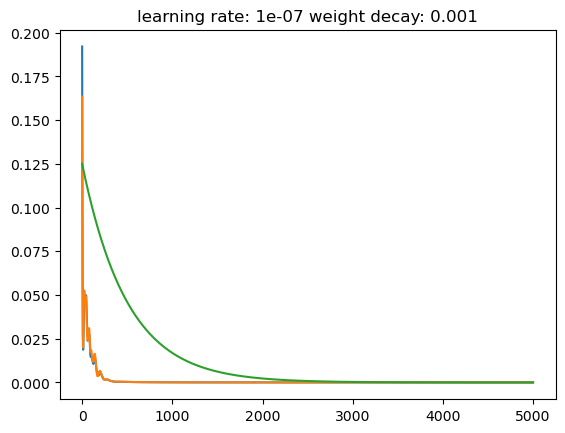

In [35]:
txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
plt.title(txt)
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot( [lr/8e-7 for lr in lrs ])
plt.show()

0.15878806916266036


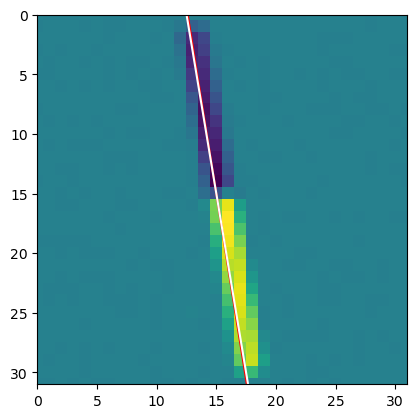

2.4219606123765938


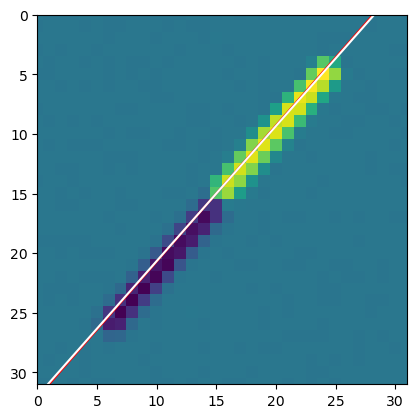

2.770922266069812


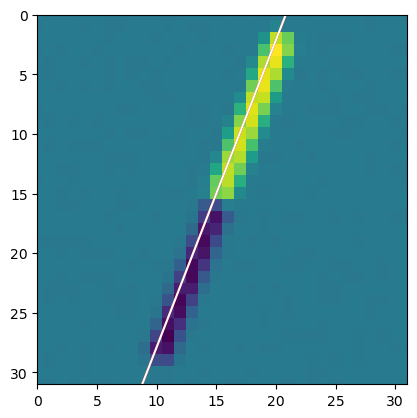

2.9603414997948136


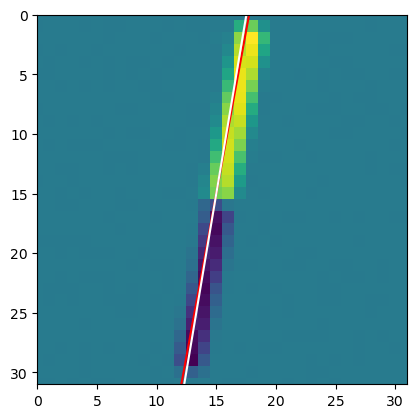

2.7719376778748672


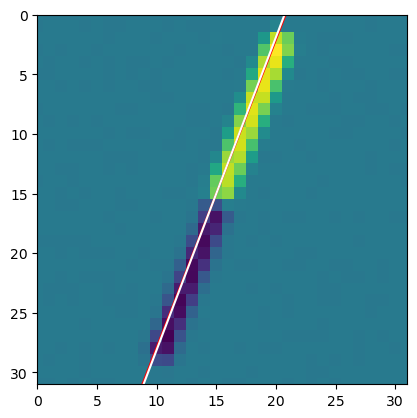

0.900192821774193


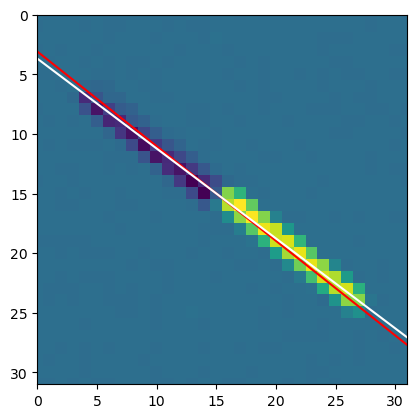

1.7746802885280837


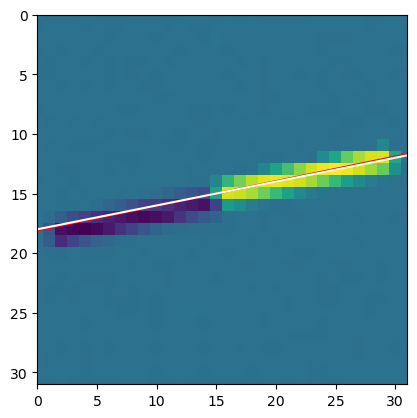

0.9934203358032223


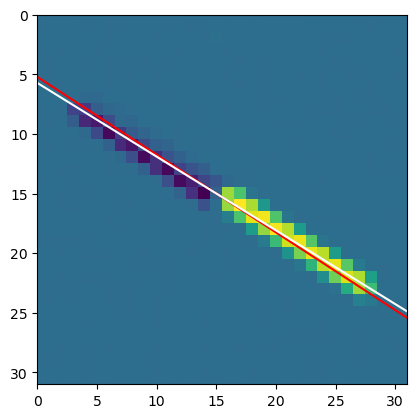

2.308952630130757


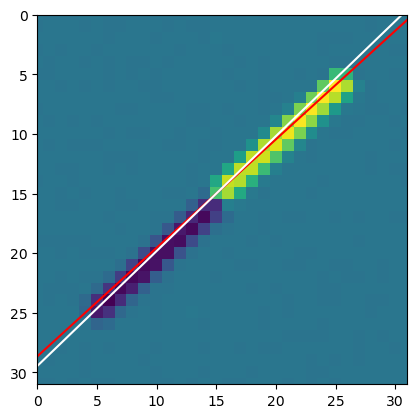

2.052168382404046


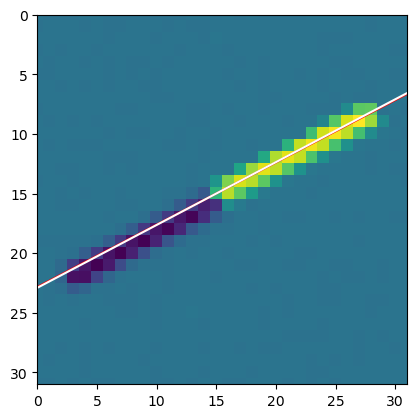

2.8247262824403045


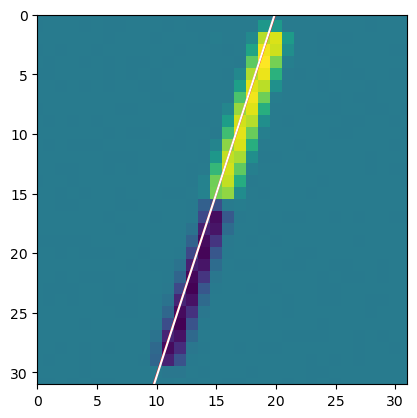

1.9939060628747718


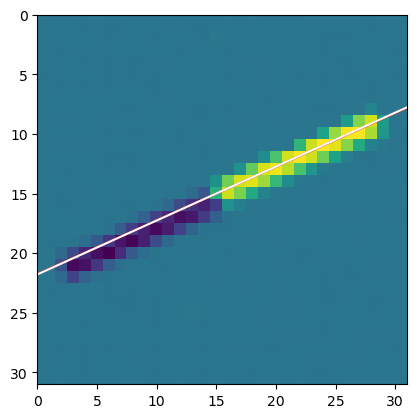

0.8355472306975931


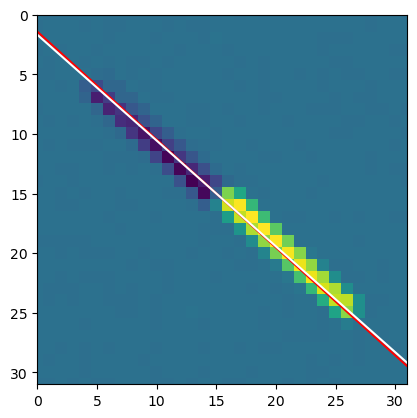

2.3176744938563303


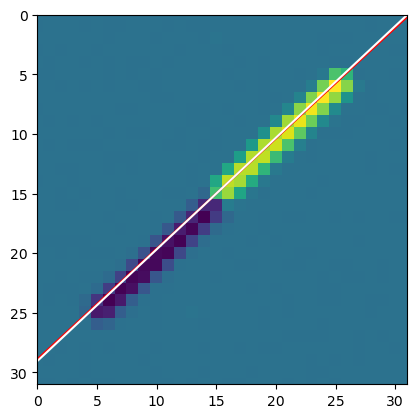

0.9289919287090135


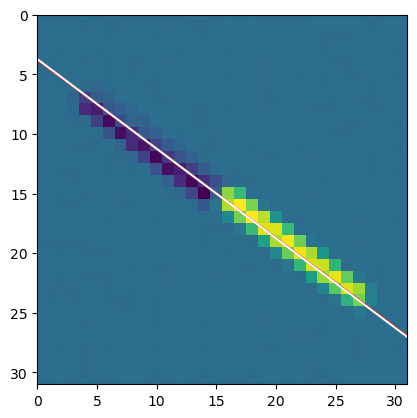

2.8348549209101117


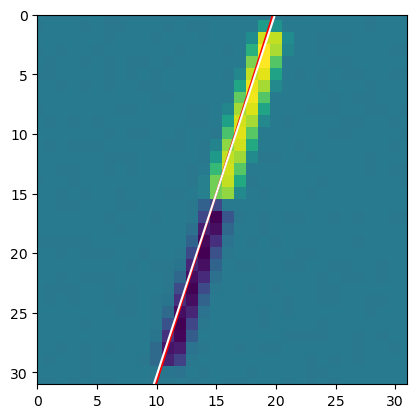

0.7995577277830008


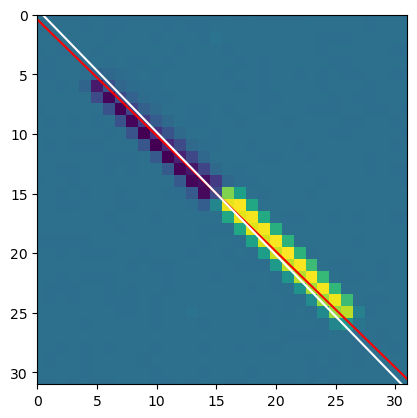

1.086470387809364


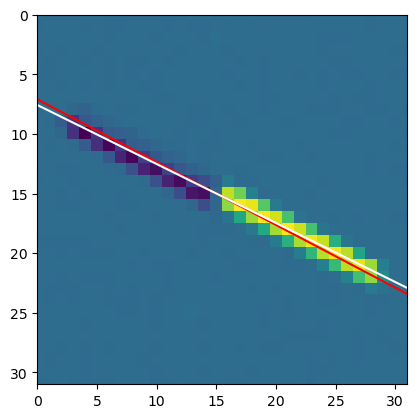

0.8549969845998739


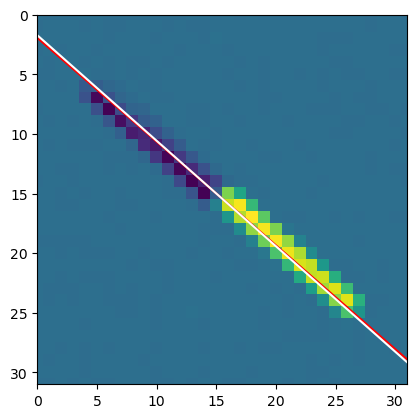

1.168696479489027


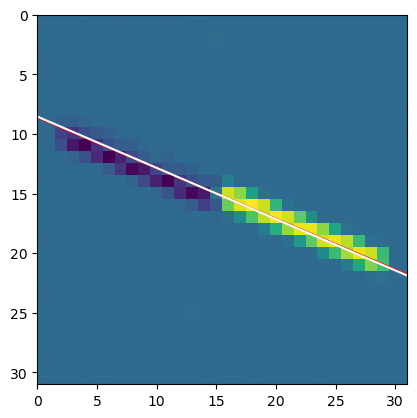

0.17862043718719697


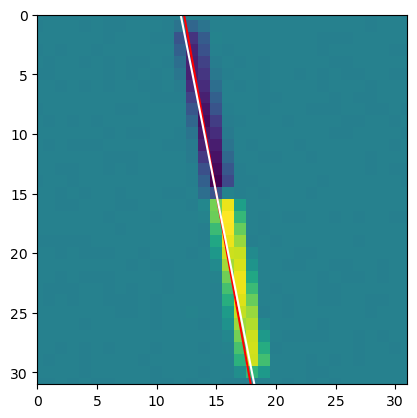

2.3521030280724973


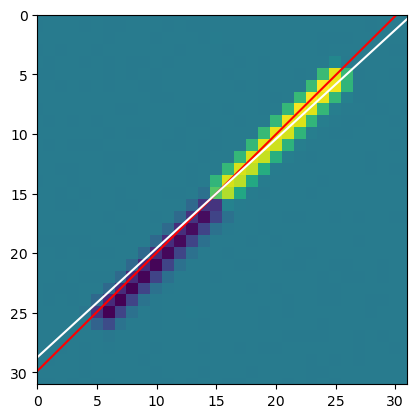

1.0497648323062718


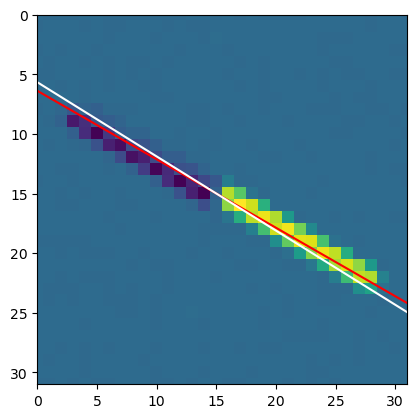

2.703869871586423


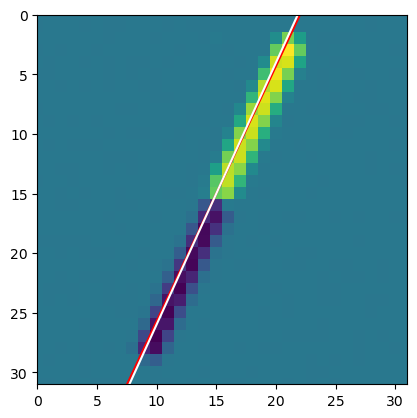

2.779067866846028


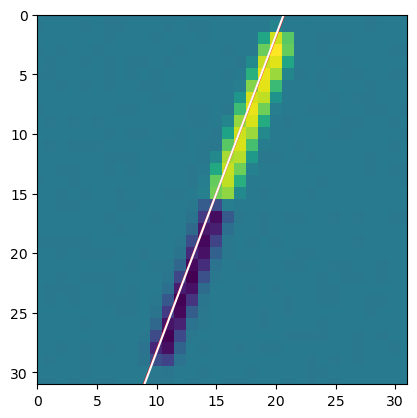

1.8837000196123643


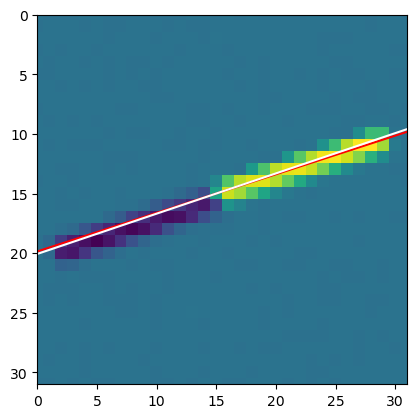

0.9300455073973068


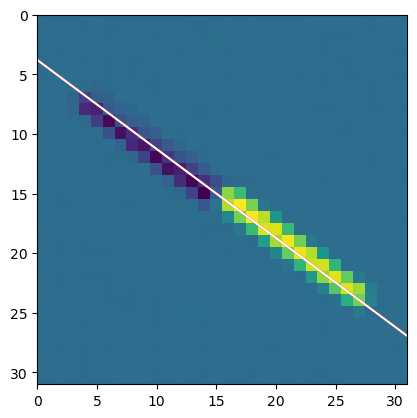

1.5415868953521712


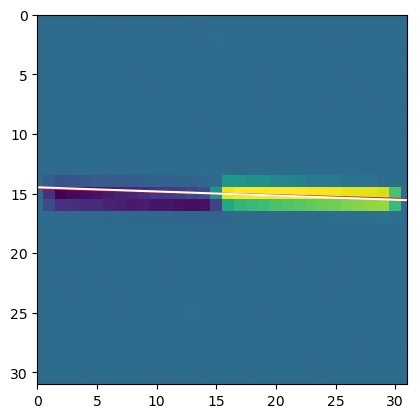

2.901016956678628


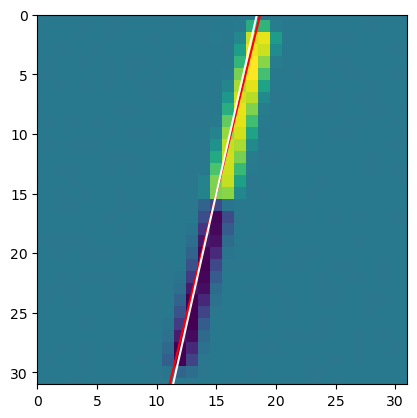

0.3413195900957858


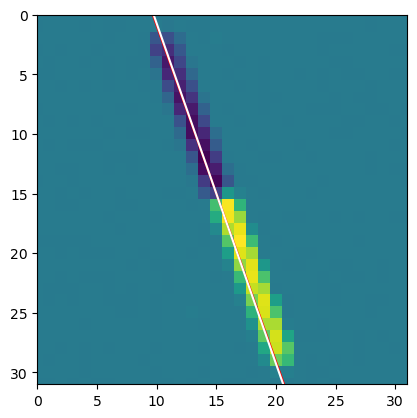

In [38]:
test_IDs = [ random.randint(0,999) for i in range(100) ]

real = []
outputs = []
for ID in test_IDs[:30]:
    input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/images/"
    label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/labels/"
    
    X = torchvision.io.read_image(
                input_dir + str(ID) + ".png "
            ).to(torch.float64)
    plt.imshow(X[1])
    X = X/256.
    
    with open(label_dir + str(ID), 'rb') as fb:
        Y  = pickle.load(fb)
        Y = Y[1][0]#/3.1415926
        
    #Y = Y + 0.5
    output = (float(model(X[1].unsqueeze(0).unsqueeze(0))) + 0.5 )*3.1415926
    print(Y)
    
    real.append(Y)
    outputs.append(output)
    
    #plt.plot( [16 - 50*math.tan(Y),16 ,16 + 50*math.tan(Y)],[16 - 50, 16,16 + 50], c='r')
    plt.plot( [15 - 50*math.tan(Y),15 ,15 + 50*math.tan(Y)],[15 - 50, 15,15 + 50], c='r')
    plt.plot( [15 - 50*math.tan(output),15 ,15 + 50*math.tan(output)],[15 - 50, 15,15 + 50], c='w')
    
    plt.xlim(0,31)
    plt.ylim(31,0)
    
    #plt.axvline( x = (Y + 1)*16, c='w' )
    #plt.axvline( x = (output + 1.)*16, c='r')
    plt.show()
    
        

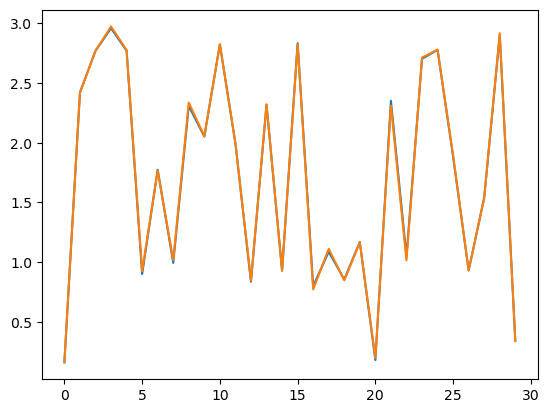

In [39]:
plt.plot(real)
plt.plot(outputs)

# WITH FLOAT32

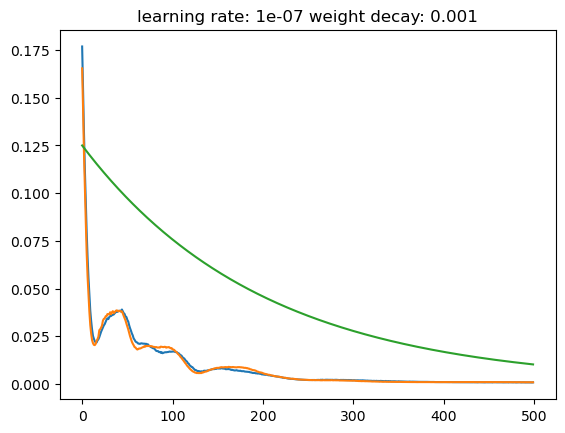

In [6]:
txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
plt.title(txt)
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot( [lr/8e-7 for lr in lrs ])
plt.show()

# WITH FLOAT64

2.1074395174873968


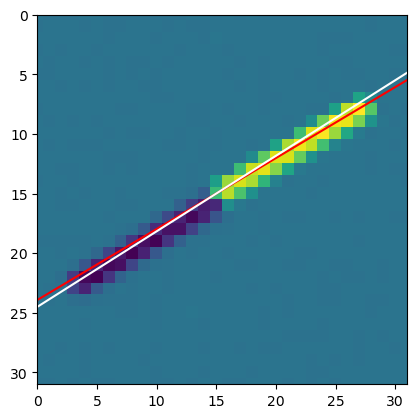

0.2673065838612102


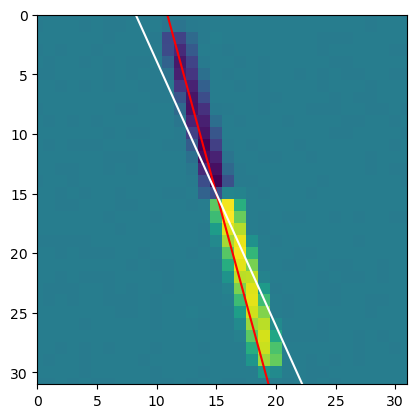

1.749268925623055


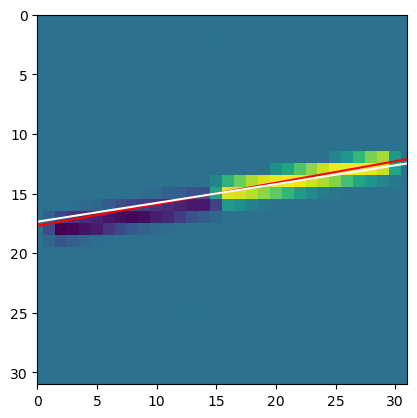

1.5480196615237665


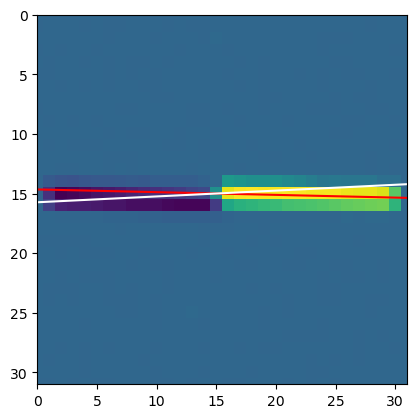

1.0224832259630878


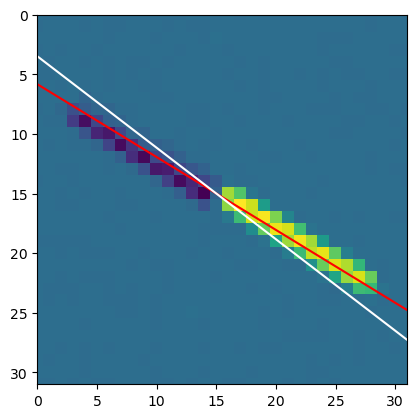

1.2399042152049646


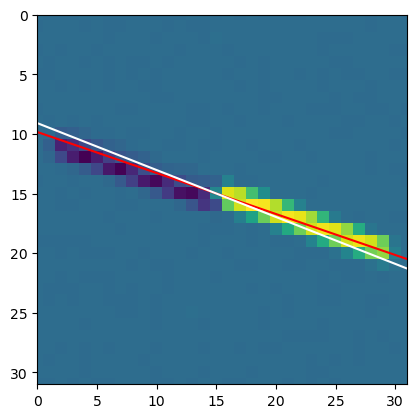

1.2613899028541484


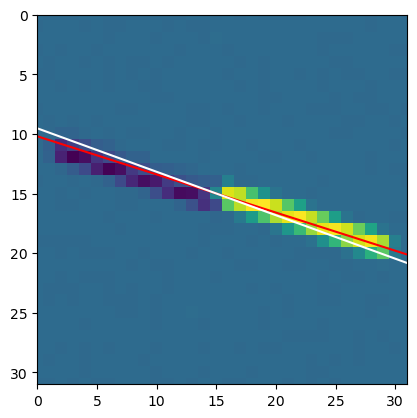

0.7741667303585109


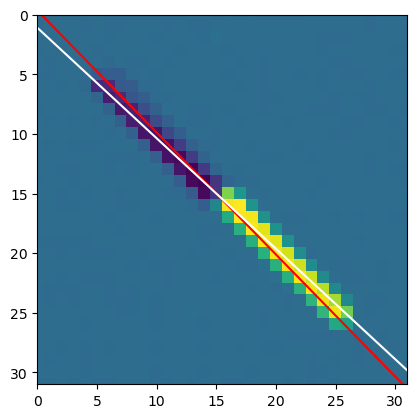

2.790313681894137


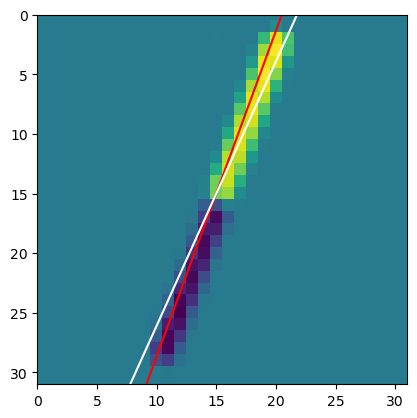

0.3250980772367107


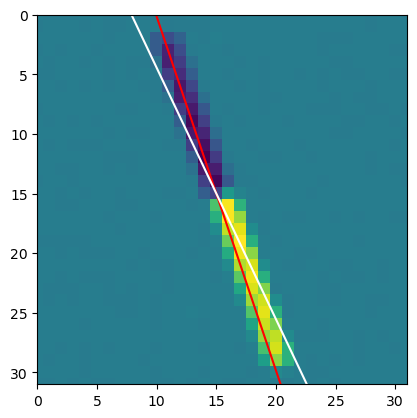

1.6306149945402901


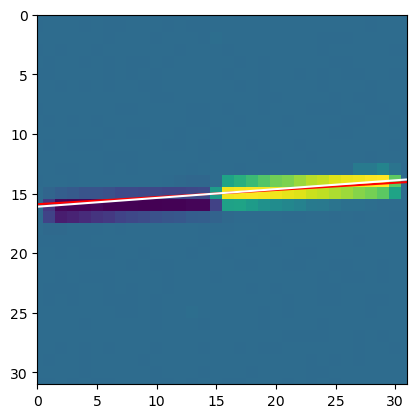

0.09193867814061174


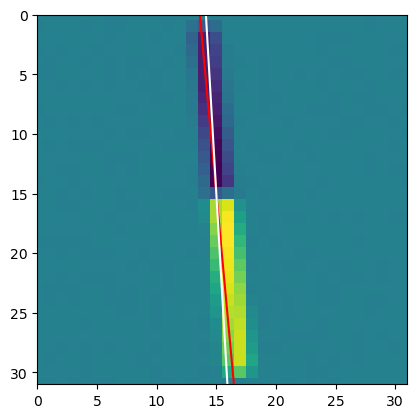

1.0656234557027602


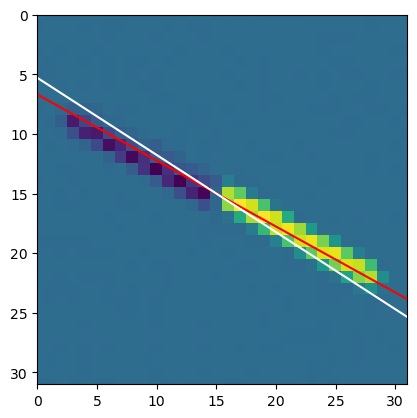

2.2000467394490015


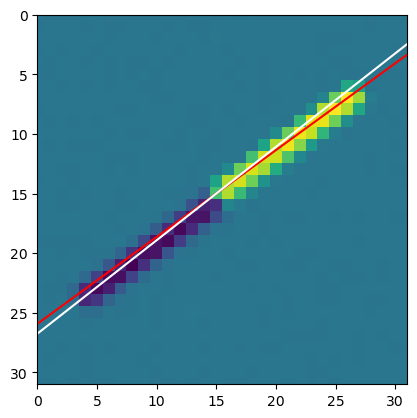

0.7837036535768435


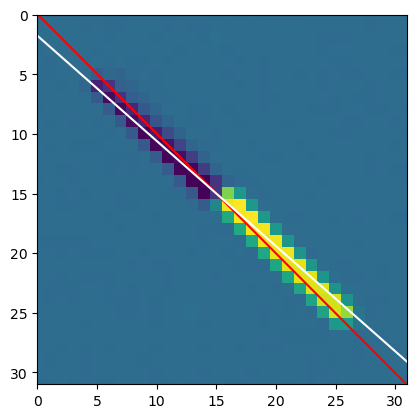

1.0030480657230685


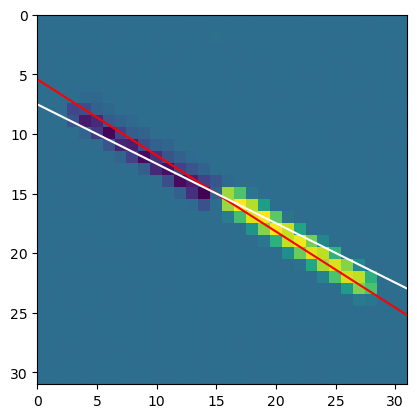

0.3947756598643114


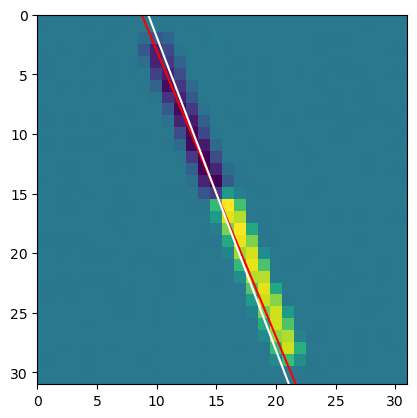

0.6449554985558988


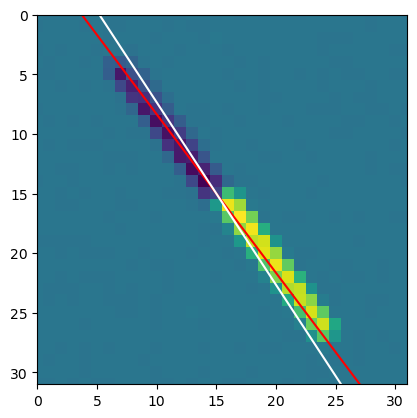

1.8247330063980387


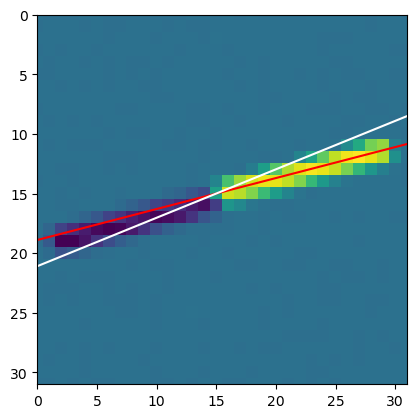

0.32719168403267823


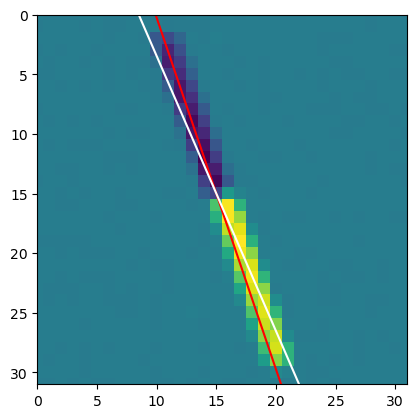

0.5047520647569124


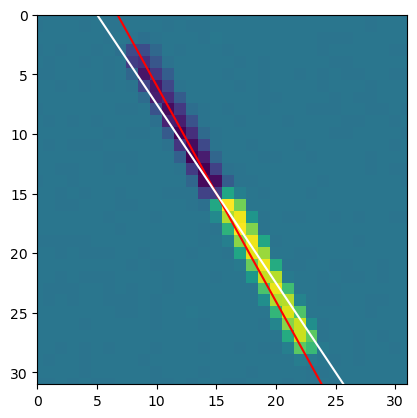

1.2951221453276136


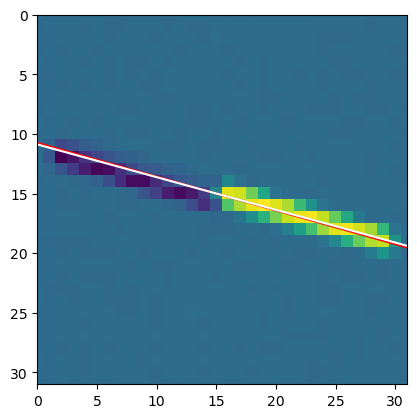

3.1042738903097074


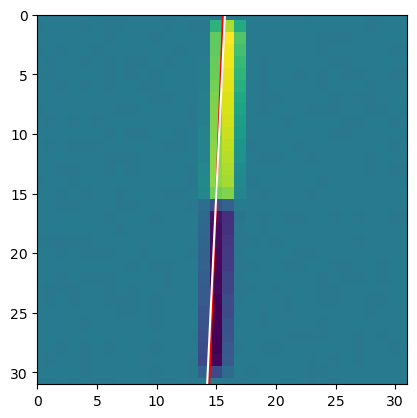

0.7262254359719155


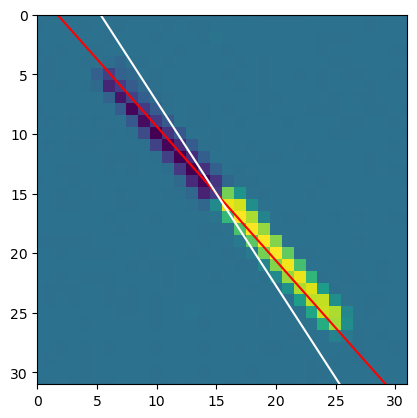

0.3956274044061136


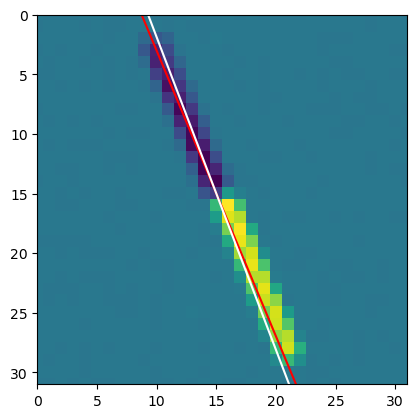

2.7413886543473955


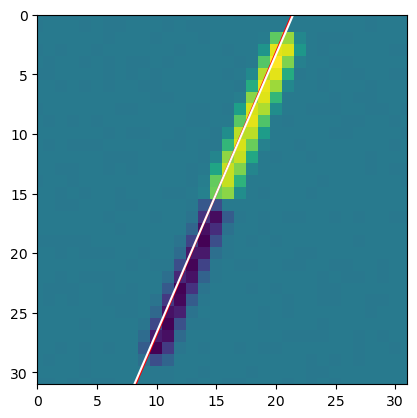

0.5810425088849986


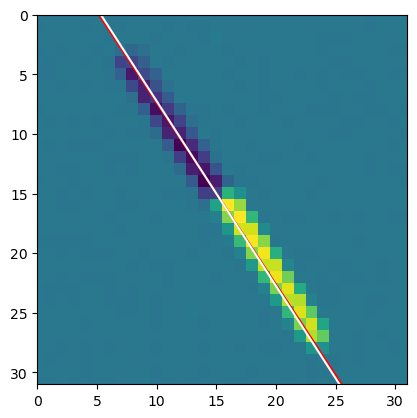

2.29984392006035


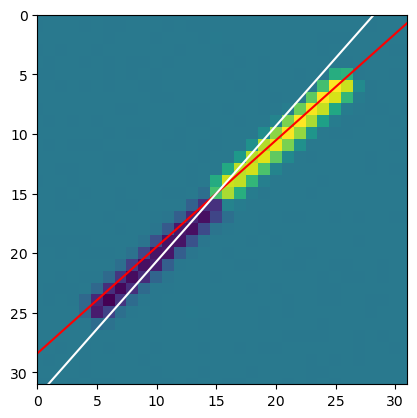

3.0455559766002174


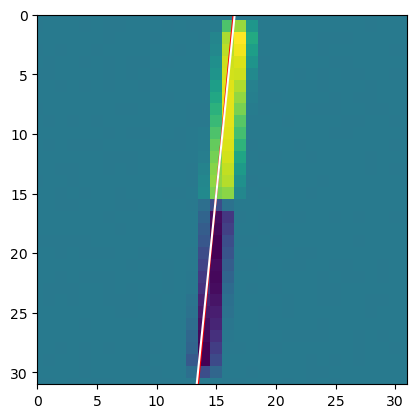

0.7021052350133623


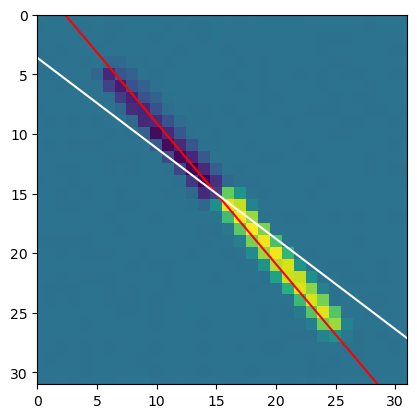

In [7]:
test_IDs = [ random.randint(0,999) for i in range(100) ]

real = []
outputs = []
for ID in test_IDs[:30]:
    input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/images/"
    label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/labels/"
    
    X = torchvision.io.read_image(
                input_dir + str(ID) + ".png "
            ).to(torch.float32)
    plt.imshow(X[1])
    X = X/256.
    
    with open(label_dir + str(ID), 'rb') as fb:
        Y  = pickle.load(fb)
        Y = Y[1][0]#/3.1415926
        
    #Y = Y + 0.5
        
    output = (float(model(X[1].unsqueeze(0).unsqueeze(0))) + 0.5 )*3.1415926
    print(Y)
    
    real.append(Y)
    outputs.append(output)
    
    #plt.plot( [16 - 50*math.tan(Y),16 ,16 + 50*math.tan(Y)],[16 - 50, 16,16 + 50], c='r')
    plt.plot( [15 - 50*math.tan(Y),15 ,15 + 50*math.tan(Y)],[15 - 50, 15,15 + 50], c='r')
    plt.plot( [15 - 50*math.tan(output),15 ,15 + 50*math.tan(output)],[15 - 50, 15,15 + 50], c='w')
    
    plt.xlim(0,31)
    plt.ylim(31,0)
    
    #plt.axvline( x = (Y + 1)*16, c='w' )
    #plt.axvline( x = (output + 1.)*16, c='r')
    plt.show()
    
        

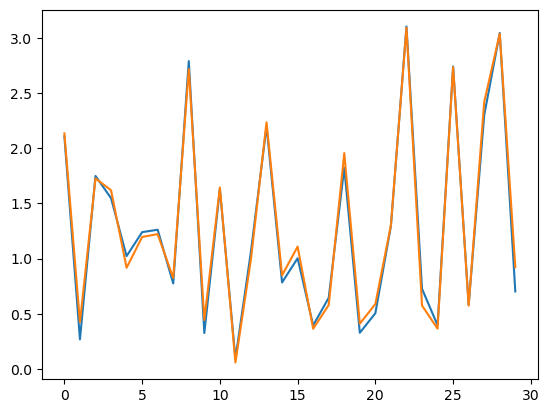

In [8]:
plt.plot(real)
plt.plot(outputs)